## 本コードの主な構成
1. 株価データ取得
2. 株価データの可視化(終値)
3. LSTMによる株価予測

#### 本コードで使用するライブラリのインストール

In [15]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from statsmodels.tsa.seasonal import STL
from scipy import interpolate

from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

### 株価データの取得
使用する株価データ:  
[任天堂(7974)](https://www.nintendo.co.jp/corporate/outline/index.html)

データ取得先:  
[stooq](https://stooq.com/)  

取得期間:  
2005/04/01 ~ 2023/12/31

In [16]:
# 取得する株価データの範囲を指定
start = '2005-04-01'
end = '2023-12-31'

df = data.DataReader('7974.JP', 'stooq', start, end)

#### 取得したデータの確認

In [17]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-12-29,7199.0,7395.0,7187.0,7359.0,6355400
2023-12-28,7095.0,7187.0,7081.0,7133.0,3074400
2023-12-27,7000.0,7133.0,6988.0,7126.0,3942400
2023-12-26,6960.0,6987.0,6944.0,6987.0,2087000
2023-12-25,6984.0,7013.0,6911.0,6934.0,1675300


In [18]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2005-04-07,1130.89,1130.89,1112.40,1118.87,11027490
2005-04-06,1099.45,1150.31,1092.98,1132.74,16012970
2005-04-05,1073.56,1100.38,1072.64,1093.91,8082720
2005-04-04,1075.41,1080.96,1064.32,1065.24,3748290
2005-04-01,1082.81,1084.66,1068.01,1074.49,4888130


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4574 entries, 2023-12-29 to 2005-04-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4574 non-null   float64
 1   High    4574 non-null   float64
 2   Low     4574 non-null   float64
 3   Close   4574 non-null   float64
 4   Volume  4574 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 214.4 KB


In [20]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

データの並べ替え

In [21]:
df.sort_values(by='Date', ascending=True, inplace=True)

グラフによる終値(`Close`)の可視化

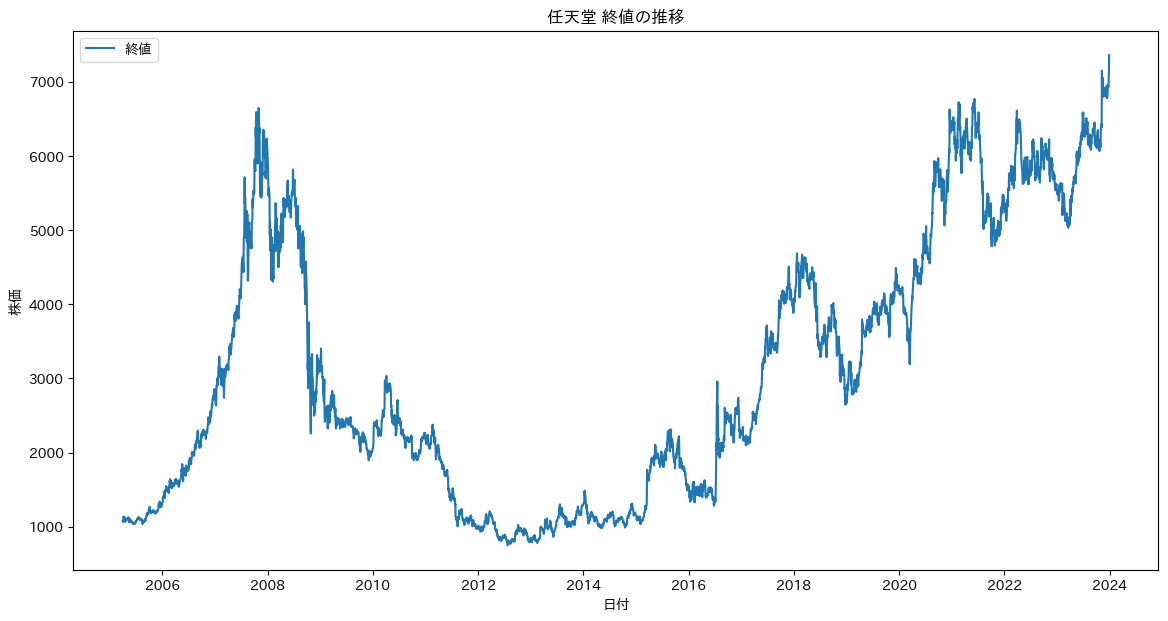

In [22]:
# 終値の折れ線グラフを作成
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='終値')
plt.title('任天堂 終値の推移')
plt.xlabel('日付')
plt.ylabel('株価')
plt.legend()
plt.show()

STL分解

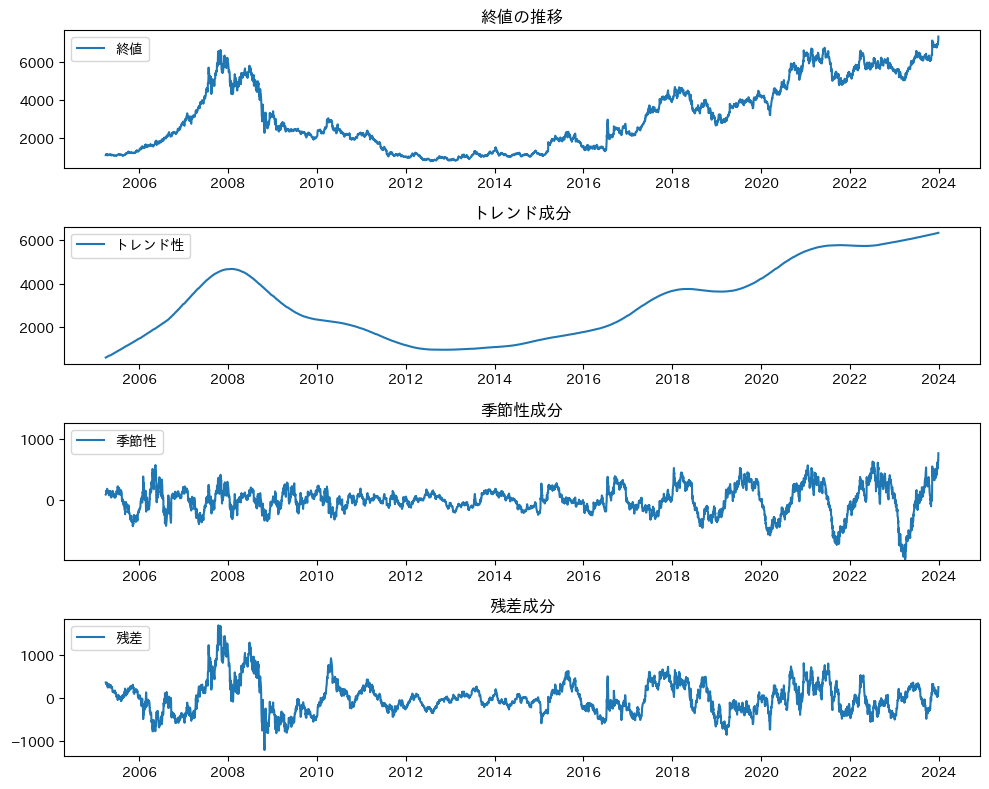

In [23]:
# STL分解の実行
stl = STL(df['Close'], period=365)
result = stl.fit()

# 分解された成分の取得
trend = result.trend
seasonal = result.seasonal
resid = result.resid

# 結果の可視化
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(df.index, df['Close'], label='終値')
plt.legend(loc='best')
plt.title('終値の推移')

plt.subplot(412)
plt.plot(df.index, trend, label='トレンド性')
plt.legend(loc='best')
plt.title('トレンド成分')

plt.subplot(413)
plt.plot(df.index, seasonal, label='季節性')
plt.ylim(seasonal.min(), seasonal.max() + 500)
plt.legend(loc='upper left')
plt.title('季節性成分')

plt.subplot(414)
plt.plot(df.index, resid, label='残差')
plt.legend(loc='upper left')
plt.title('残差成分')

plt.tight_layout()
plt.show()

#### 上記結果から解釈すること
- 長期的には上昇トレンド(トレンド成分から)
- 季節性の影響は限定的であるが、近年その重要性が増している(季節性成分から)
- 市場の効率性は2008年以降、徐々に改善傾向にあることが示唆される(残差成分から)

### LSTMを用いた株価予測モデル作成

#### データの正規化

In [24]:
# 終値のスケーリング
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

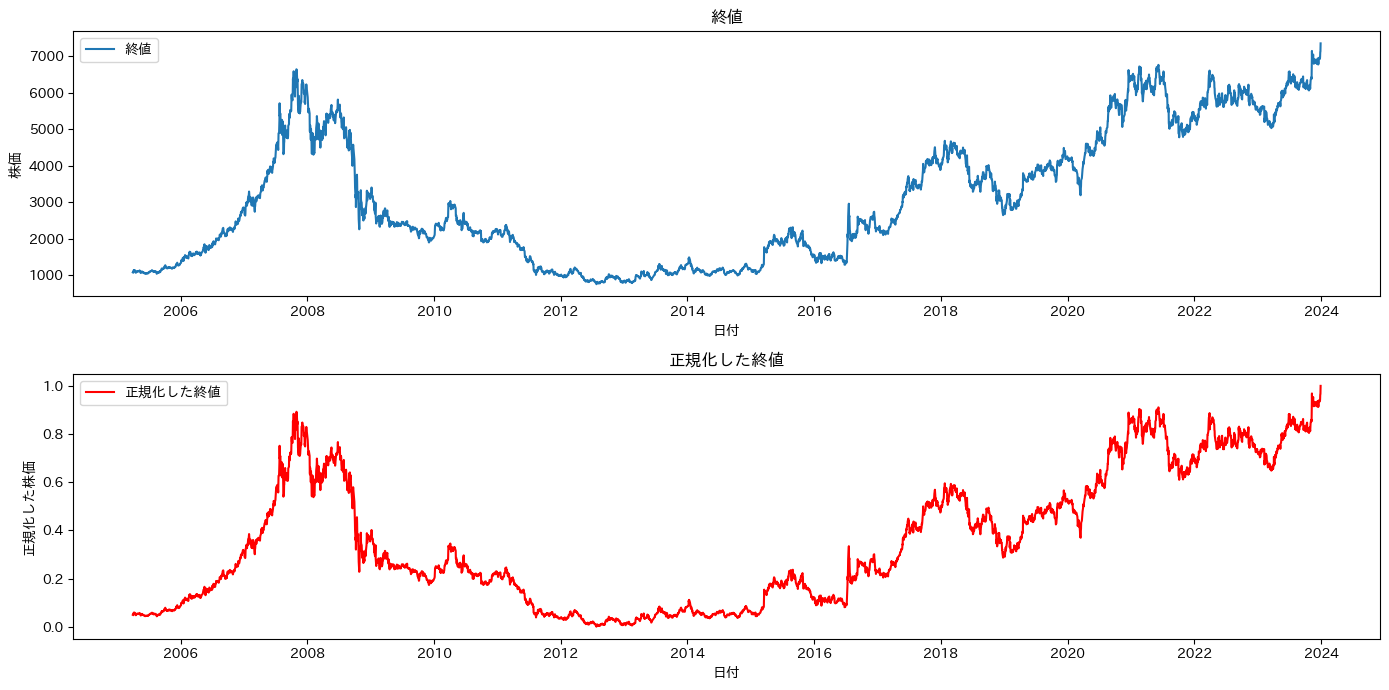

In [25]:
plt.figure(figsize=(14, 7))

# 正規化前
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='終値')
plt.title('終値')
plt.xlabel('日付')
plt.ylabel('株価')
plt.legend()

# 正規化後
plt.subplot(2, 1, 2)
plt.plot(df.index, scaled_data, label='正規化した終値', color='red')
plt.title('正規化した終値')
plt.xlabel('日付')
plt.ylabel('正規化した株価')
plt.legend()

# レイアウト調整
plt.tight_layout()
plt.show()

#### データ準備

In [26]:
# 訓練データとテストデータの分割
training_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

# データをLSTM用に変換
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [32]:
time_step = 5
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# LSTMの入力の形状に変換
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#### モデル構築、および訓練

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/opt/anaconda3/envs/shinkuma_lab/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=24, epochs=40)

Epoch 1/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108
Epoch 2/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3092e-04
Epoch 3/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4356e-04
Epoch 4/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8829e-04
Epoch 5/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9837e-04
Epoch 6/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.5913e-04
Epoch 7/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9449e-04
Epoch 8/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1100e-04
Epoch 9/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3328e-04
Epoch 10/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9324e-04
Epoch 11/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8851e-04
Epoch 12/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4392e-04
Epoch 13/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1701e-04
Epoch 14/40
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0018e-04
Epoch

#### テストデータを用いた予測

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

mse = mean_squared_error(y_test[0], test_predict[:, 0])
r2 = r2_score(y_test[0], test_predict[:, 0])

print('MSE: {:.2f}'.format(mse))
print('R^2: {:.2f}'.format(r2))

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE: 9652.31
R^2: 0.97


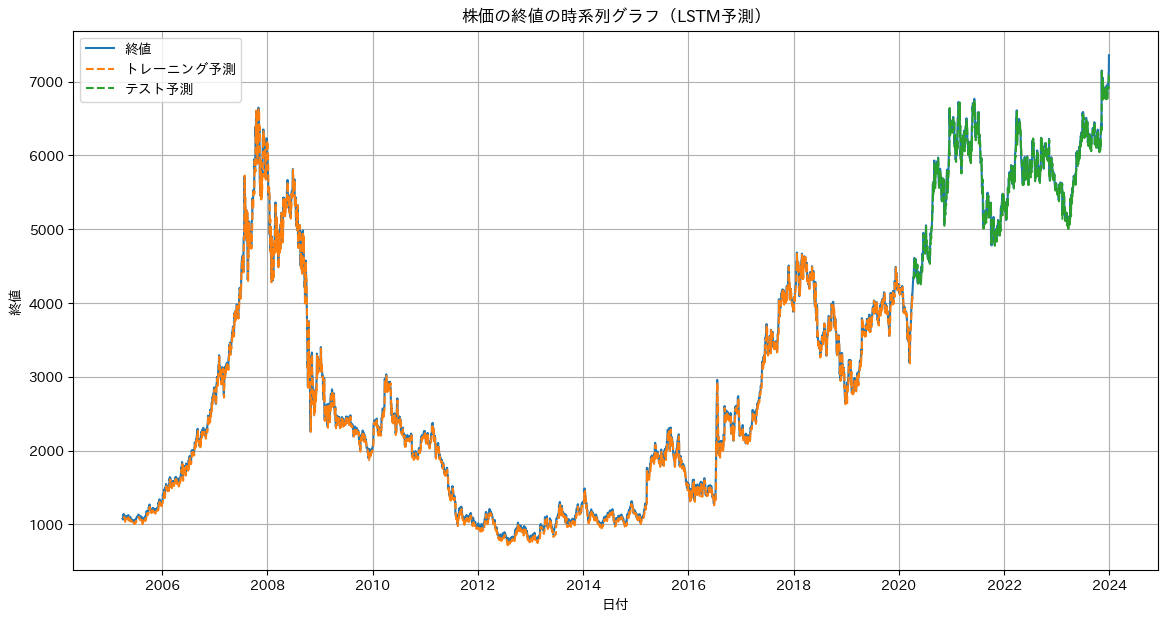

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='終値')
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(df.index, train_predict_plot, label='トレーニング予測', linestyle='--')

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict
plt.plot(df.index, test_predict_plot, label='テスト予測', linestyle='--')

plt.xlabel('日付')
plt.ylabel('終値')
plt.title('株価の終値の時系列グラフ（LSTM予測）')
plt.legend()
plt.grid(True)
plt.show()